# Notebook with the models and results for the 9 month report. 

## Contense
### 1 Phosphoproteomic models
#### 1.1 all drugs model (ADM) with replica cell ines for validation
#### 1.2 ADM with unique cell liens for validaiton
### 2 RNA-seq models 
#### 2.1 small RNA-seq data set model 
#### 2.2 big RNA-seq data set model 
### 3 statistical tests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import scipy
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import scale  
import os
import copy 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from Input_data import *
from Plot_funcs import *


DIRECT = os.path.dirname(os.getcwd()) #gets current director
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import norm

In [2]:
#tranning cell lines used in DRUML, found from DRUML github
DRUML_train_cells = ['KYSE.150',
 'KYSE.150.1',
 'KYSE.150.2',
 'KYSE.140',
 'KYSE.140.1',
 'KYSE.70',
 'KYSE.70.1',
 'KYSE.70.2',
 'COLO.680N',
 'COLO.680N.1',
 'COLO.680N.2',
 'OE19',
 'OE19.1',
 'OE33.2',
 'KYSE.520',
 'KYSE.520.1',
 'KYSE.520.2',
 'KYSE.450.1',
 'KYSE.450.2',
 'KYSE.510',
 'KYSE.510.1',
 'KYSE.510.2',
 'KYSE.410',
 'KYSE.410.1',
 'KYSE.410.2',
 'SK.HEP.1',
 'SK.HEP.1.1',
 'SK.HEP.1.2',
 'SNU.475',
 'SNU.475.1',
 'SNU.475.2',
 'HEP.G2.1',
 'HEP.3B',
 'HEP.3B.1',
 'HEP.3B.2',
 'PLC.PRF.5.2',
 'JHH.2',
 'JHH.2.1',
 'JHH.2.2',
 'SNU.449',
 'SNU.449.1',
 'SNU.449.2',
 'SNU.387',
 'SNU.387.1',
 'SNU.423',
 'SNU.423.1',
 'SNU.398',
 'SNU.398.1',
 'SNU.398.2',
 'SNU.182',
 'SNU.182.1',
 'SNU.182.2',
 'JHH.4',
 'JHH.4.1']

In [38]:
#useful funcs used in notebook
def add_repeats_simp(unique_inds):
    '''For unique cell lines inds adds repeted cell lines inds

    only for simple x where all repets come after each other
    e.g. x = [CLa, Cla.1, CLa.2] not x = [CLa, CLb, CLa.1]
    '''
    num_repeats = 3
    final_inds = []
    for i in unique_inds:
        for j in range(num_repeats):
            final_inds.append(i + j)
    final_inds = np.array(final_inds)
    return final_inds

def split_data(x, test_size=0.8):
    unique_inds = np.arange(0, len(x), 3) 
    test_inds, train_inds = train_test_split(
        unique_inds, test_size = test_size, random_state=50)
    test_inds = add_repeats_simp(test_inds)
    train_inds = add_repeats_simp(train_inds)
    test_cls = x.index[test_inds]
    train_cls = x.index[train_inds]
    return train_cls, test_cls

def norm_data(sklearn_scaler):
    scale =  sklearn_scaler()
    ppindex = pd.DataFrame(scale.fit_transform(ppindex_no_norm),
                           columns = ppindex_no_norm.columns,
                           index = ppindex_no_norm.index)

    ppindex_colo = pd.DataFrame(scale.fit_transform(ppindex_colo_no_norm),
                           columns = ppindex_colo_no_norm.columns,
                           index = ppindex_colo_no_norm.index)
    return ppindex.T, ppindex_colo.T

def find_markers(drug_name, EMDR_df):
    drug_df = EMDR_df[EMDR_df['drugs'] == drug_name]
    
    
    marker_type = ['sensitive_markers','resistant_markers']
    
    #stores [senstive,resistant] where senstive and resistant are lists of 
    #senstive and resistant markers
    senstive_resistant_markers = [] 
    for MT in marker_type:
        markers_list =  []
        senstive_resistant_markers.append(
            np.array(drug_df[MT].values[0].split('-')))
        
    #list of lists, with [senstive,resistant]
    return senstive_resistant_markers 


def create_all_drugs(x, y, cells, data_split=False):
    '''create data for all drugs returns x, xdrug, y
    
    '''
    drug_inds = []
    x_dfs = []
    x_drug_dfs = []
    y_final = []
    #only takes the testing or traning cells if data has not yet been split
    if data_split:
        pass
    else:
        y = y.loc[cells]
        x = x.loc[cells]
    x.astype(np.float16)
    for i, d in enumerate(all_drugs):
        #find cell lines without missing truth values
        y_temp = y[d]
        nona_cells = y_temp.index[~np.isnan(y_temp)]
        #finds the index for the start / end of each drug
        ind_high = len(nona_cells) + i
        drug_inds.append((d, i, ind_high))
        i +=  len(nona_cells)

        #store vals of the cell lines with truth values
        x_pp = x.loc[nona_cells] 
        x_dfs.append(x_pp)
        X_drug = pd.DataFrame([one_hot_durgs[d]] * len(x_pp))
        x_drug_dfs.append(X_drug)
        y_final.append(y_temp.dropna())

    #combine values for all drugs  
    x_final = pd.concat(x_dfs, axis=0)
    X_drug_final = pd.concat(x_drug_dfs, axis=0)
    y_final = pd.concat(y_final, axis = 0)
    return x_final, X_drug_final, y_final

def plot_colo(results, re=3, verb=False, ret=False):
    all_r2, all_spear = [], []
    cls_order = []
    for i in np.arange(0,len(results.keys()), re):
        cell_line = list(results.keys())[i]
        colo_true = []
        colo_pre = []
        for t,p in results[cell_line]:
            colo_true.append(t)
            colo_pre.append(p)
        if verb:
            scatter_predit_true([],[],colo_true,colo_pre)
        else: 
            pass
        spear = scipy.stats.spearmanr(colo_true, colo_pre)
        print(spear)
        r2 = r2_score(colo_true, colo_pre)
        print(f'R2: {r2}')
        print(len(colo_true), cell_line)
        all_r2.append(r2)
        cls_order.append(cell_line)
        all_spear.append(spear[0])
    if ret:
        return np.array(all_r2), np.array(all_spear), cls_order
            
def plot_cv(test, val, epochs, err=2, skip_epochs=0, y_lab='Loss', 
           save_name=''):
    '''Func to plot the cross validation loss or metric
    
    Parameters
    test: list, of length number of cv folds, with each element of the list
    contaning a lists with the test set loss or metric. 
        
    val: same as test but with validation data  
    
    epochs: number of epochs model traiend for
    
    err: 0 1 or 2, defalt=2
    If 0, no error plotted
    If 1, error bars (s.d) plotted
    If 2, contionus error plotted
    
    skip_epochs: int, defalt=0
    number of epochs to skip at the start of plotting 
    
    y_lab: str, defalt=loss
    y label to plot
    
    save_name: str, defalt=''
    file_path\name to save fig. if defalt fig not saved
    '''
    x = range(1, epochs + 1 - skip_epochs) 
    val_mean = cv_metric(val, np.mean)
    test_mean = cv_metric(test, np.mean)
    val_sd = cv_metric(val, np.std)
    test_sd = cv_metric(test, np.std)
    
    if err == 1:
        plt.errorbar(
            x, test_mean[skip_epochs: ], yerr= test_sd[skip_epochs: ], 
            label='Test')
        plt.errorbar(
            x, val_mean[skip_epochs: ],  yerr = val_sd[skip_epochs: ], 
            label='Validation')
        plt.fill_between(
            x, test_mean[skip_epochs: ] - test_sd[skip_epochs: ], 
            yfit + test_sd[skip_epochs: ], color='gray', alpha=0.2)
        
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(y_lab)
        
    if err == 2:
        plt.plot(x, test_mean[skip_epochs: ], label='Test')
        plt.plot(x, val_mean[skip_epochs: ], label='Validation')
        plt.fill_between(x, test_mean[skip_epochs: ] - test_sd[skip_epochs: ], 
                         test_mean[skip_epochs: ] + test_sd[skip_epochs: ], 
                         color='gray', alpha=0.8)
        plt.fill_between(x, val_mean[skip_epochs: ] - val_sd[skip_epochs: ], 
                 val_mean[skip_epochs: ] + val_sd[skip_epochs: ], 
                 color='gray', alpha=0.8)

        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(y_lab)        
        
    else: 
        plt.plot(x, test_mean[skip_epochs: ], label = 'Test')
        plt.plot(x, val_mean[skip_epochs: ], label = 'Validation')
        plt.legend()
        
    if save_name:
        plt.savefig(save_name, dpi=1000)
        
    plt.show()
        
def cv_metric(metric, func):
    """Finds func of cv across a number of epochs as outputted from run_cv
    
    e.g. for func = np.mean gives mean at each epoch
    """
    metricT = np.array(metric).T
    result = []
    for i in range(len(metricT)):
        result.append(func(metricT[i]))
    return np.array(result)



def best_metric(metric):
    m = cv_metric(metric, np.mean)
    argmin = np.argmin(m)
    return m[argmin] , argmin

#need to find missing features 
#(i.e. sites thata were not found in clin data but were in data from DRUML)
def replace_missing_features(druml_sites, x_inid):
    inid_sites = x_inid.columns
    shared_features = []
    missing_features = []
    for f in druml_sites:
        if np.sum(f == inid_sites) > 0:
            shared_features.append(f)
        else:
            missing_features.append(f)
            
    subset_indi = x_inid[shared_features]
    for f in missing_features:
        subset_indi[f] = np.zeros(len(x_inid))         

    return subset_indi


# 1. Phoso data reading and formatting 

In [4]:
emdrs_rna_raw = pd.read_csv('downloaded_data/EMDR_rna_solid.csv')
emdrs_rna_raw.drop(columns='Unnamed: 0', inplace=True)
#find EMDR's 
senT = []
resT = []
for d in emdrs_rna_raw['drugs']:
    sen_res = find_markers(d, emdrs_rna_raw)
    senT.extend(sen_res[0])
    resT.extend(sen_res[1])
all_markers = senT + resT
emdrs_rna = np.unique(all_markers)

AML=False #aml or solid tumer data
#data imports 
y_AML_full_no_norm, ppindex_no_norm, emdrs_raw = read_pp_AAC_EMDR(AML=AML)
ppindex_colo_no_norm, y_colo_no_norm = load_colo()
all_drugs = y_AML_full_no_norm.columns

#drug one hot encoding
frame = {}
for i,d in enumerate(y_AML_full_no_norm.columns):
    hot_vec = np.zeros(len(y_AML_full_no_norm.columns))
    hot_vec[i] = 1
    frame[d] = hot_vec
one_hot_durgs = pd.DataFrame(frame)

solid_remove = ['HEP.G2.1', 'HEP.3B', 'HEP.3B.1','HEP.3B.2',
              'HEP.G2.2', 'HEP.G2']

if AML:
    pass
else:
    ppindex_no_norm.drop(solid_remove, axis=1, inplace=True)

ALL_CLS = ppindex_no_norm.columns



In [5]:
#EMDR formatting and feature selection methods
#remove first two sites '09/02/18 00:00:00(S218);', '09/09/18 00:00:00(S30);'
#as clearly mistake
#'DOB(S97);', 'HLA' are also missing from the DRUML data for somereason 
missing = ['DOB(S97);', 'HLA', '09/02/18 00:00:00(S218);', 
           '09/09/18 00:00:00(S30);', '13(S82);', 
           '13(S82);IGKV1', '5(S82);IGKV1D', 
           'None(S60);IGKV1']

missing_inds = [np.where(emdrs_raw == m)[0][0] for m in missing]
emdrs = np.delete(emdrs_raw, missing_inds)

def emdr_selection(x):
    return x[emdrs]
 
def feature_select(x, func, y=[], cls=[], indi_dat=False, test=True):
    '''Finds features for inidipedent test or train datasets
    
    '''
    if test:
        if indi_dat:
            x = replace_missing_features(ppindex.columns, 
                                         x.loc[cls])
        else:
            x = x.loc[cls]
        x = func(x)
        y = y.loc[cls]
        return x, y 
    else:
        x = func(x)
        return x

# 1.1 Replical cell line all drugs model (ADM)

## Train test split and feature seleciton

In [6]:
#norm by cell line
'''MinMaxScaler is a parm I could expriemnt with
'''
ppindex, ppindex_colo = norm_data(MinMaxScaler)

#take cls with no truth values
ppindex_colo = ppindex_colo.iloc[2:] 
ppindex_colo = ppindex_colo.iloc[:18]
ppindex_colo.index = y_colo_no_norm.index #more readable cell names

#test train split
#DRUM test train split 
train_cls_rep, test_cls_rep = [], []
for c in ALL_CLS:
    if c in DRUML_train_cells:
        train_cls_rep.append(c)
    else:
        test_cls_rep.append(c)
#using my t/t split 
'''
test_cls_rep, train_cls_rep = train_test_split(
    ALL_CLS, test_size=0.8, random_state=49)
'''

#combine data from all drugs into one df
x_pp_train, x_drug_train, y_list_train = create_all_drugs(
    ppindex, y_AML_full_no_norm, train_cls_rep)
print(x_pp_train.shape, x_drug_train.shape, len(y_list_train))

(20757, 22804) (20757, 431) 20757


In [7]:
feature_select_func = emdr_selection
x_pp_train = feature_select(x_pp_train, feature_select_func, test=False)
x_pp_test, y_test = feature_select(
    ppindex, feature_select_func, y=y_AML_full_no_norm, cls=test_cls_rep)
x_pp_colo, y_colo = feature_select(
    ppindex_colo, feature_select_func, y=y_colo_no_norm, 
    cls=y_colo_no_norm.index, indi_dat=True)

/tmp/2418822.1.all.q/ipykernel_47264/694811990.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_indi[f] = np.zeros(len(x_inid))
/tmp/2418822.1.all.q/ipykernel_47264/694811990.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_indi[f] = np.zeros(len(x_inid))


## Model building and validation

In [8]:
def run_cv(m_func, x, y, hp, epochs=10, k=10, p=1):
    '''runs k fold cv p times with repeats in vali set
    
    '''
    cv = RepeatedKFold(n_splits=k, n_repeats=p) 
    loss = []
    val_loss = []
    val_mae = []
    #x_pp, x_drug = x
    
    i = 0
    for train_i, val_i in cv.split(x[0]):
        print(i / k)
        i += 1
        model = m_func(hp)
        hist = model.fit(
            [x[0].iloc[train_i], x[1].iloc[train_i]], 
            y.iloc[train_i],
            validation_data=(
                [x[0].iloc[val_i], x[1].iloc[val_i]], 
                y.iloc[val_i]),
            epochs=epochs, 
            batch_size=8,
            verbose=0)
        
        loss.append(hist.history['loss'])
        val_loss.append([hist.history['val_loss']])
        val_mae.append(hist.history['val_mae'])
        
    return loss, val_loss, val_mae


def pre_test(model, x, y, verb=False, combined=False, drugs=all_drugs):
    results  = {}
    all_true, all_pre, all_rmse = [], [], []
    
    for i, d in enumerate(drugs):
        mask = y[d].notnull()
        x_drug = x[mask]
        one_drug = np.zeros((x_drug.shape[0], len(drugs)) )
        one_drug = pd.DataFrame(one_drug)
        one_drug[i] = 1
        y_drug = y[mask.values][d]
        if len(x_drug) != 0: #some drugs have no cell lines with truth values
            predict_drug = model.predict([np.expand_dims(x_drug ,axis = -1 ),
                                               one_drug[0:len(x_drug)]])

            all_true.extend(y_drug)
            all_pre.extend(predict_drug)
            for i, c in enumerate(y_drug.index):
                try:
                    results[c].append((y_drug[c], predict_drug[i][0]) )
                except KeyError:
                    results[c] = [ (y_drug[c], predict_drug[i][0])]

            all_rmse.append(
                mean_squared_error(y_drug, predict_drug, squared=False))
        if verb: 
            print(d,r2_score(y_drug, predict_drug))
            scatter_predit_true([],[],y_drug, predict_drug)
    if combined:
        scatter_predit_true([], [], all_true, all_pre)
        print(len(all_true))
        rmse = mean_squared_error(all_true, all_pre, squared=False)
        print(
            f'N: {len(all_true)}, RMSE: {rmse}, r2: {r2_score(all_true, all_pre)}')
    return [results, all_rmse]





In [9]:
def build_DNN(num_uni):
    phos_input = layers.Input(shape=x_pp_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    x = layers.Dense(num_uni, activation='relu')(x)
    drug_input = layers.Input(shape = (x_drug_train.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    hidd = layers.Dense(num_uni // 2, activation='relu')(hidd)
    output_tensor = layers.Dense(1, activation='sigmoid')(hidd)
    model = models.Model([phos_input,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [10]:
epochs=200
loss, val_loss, val_mae = run_cv(
    build_DNN, 
    [x_pp_train, x_drug_train], 
    y_list_train, 
    128, 
    epochs=epochs, 
    p=1, 
    k=3)

0.0


2022-06-13 17:44:29.334446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 17:44:34.322653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38410 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0
2022-06-13 17:44:35.403469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-13 17:44:42.236657: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.3333333333333333
0.6666666666666666


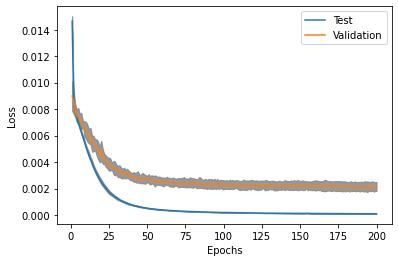

(0.002126119409998258, 188)

In [11]:
plot_cv(loss, val_loss, epochs, err=2) 
best_metric(val_loss)

## Model testing

In [20]:
model_rep = build_DNN(128)
_ = model_rep.fit([x_pp_train, x_drug_train], y_list_train, 
                  epochs=200, batch_size=64)


Epoch 1/200
325/325 [==============================] - 2s 4ms/step - loss: 0.0165 - mae: 0.0933
Epoch 2/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0080 - mae: 0.0614
Epoch 3/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0074 - mae: 0.0585
Epoch 4/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0068 - mae: 0.0559
Epoch 5/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0060 - mae: 0.0525
Epoch 6/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0053 - mae: 0.0491
Epoch 7/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0046 - mae: 0.0457
Epoch 8/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0039 - mae: 0.0421
Epoch 9/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0034 - mae: 0.0387
Epoch 10/200
325/325 [==============================] - 1s 4ms/step - loss: 0.0029 - mae: 0.0358
Epoch 11/200
325/325 [=================

325/325 [==============================] - 1s 4ms/step - loss: 1.0509e-04 - mae: 0.0070
Epoch 83/200
325/325 [==============================] - 1s 4ms/step - loss: 1.0556e-04 - mae: 0.0069
Epoch 84/200
325/325 [==============================] - 1s 4ms/step - loss: 1.0373e-04 - mae: 0.0070
Epoch 85/200
325/325 [==============================] - 1s 4ms/step - loss: 1.0020e-04 - mae: 0.0069
Epoch 86/200
325/325 [==============================] - 1s 4ms/step - loss: 9.8682e-05 - mae: 0.0068
Epoch 87/200
325/325 [==============================] - 1s 4ms/step - loss: 1.0069e-04 - mae: 0.0068
Epoch 88/200
325/325 [==============================] - 1s 4ms/step - loss: 9.9427e-05 - mae: 0.0068
Epoch 89/200
325/325 [==============================] - 1s 4ms/step - loss: 9.4542e-05 - mae: 0.0067
Epoch 90/200
325/325 [==============================] - 1s 4ms/step - loss: 9.6595e-05 - mae: 0.0067
Epoch 91/200
325/325 [==============================] - 1s 4ms/step - loss: 9.4278e-05 - mae: 0.0067
Epo

325/325 [==============================] - 1s 4ms/step - loss: 4.8759e-05 - mae: 0.0048
Epoch 163/200
325/325 [==============================] - 1s 4ms/step - loss: 4.9071e-05 - mae: 0.0048
Epoch 164/200
325/325 [==============================] - 1s 4ms/step - loss: 4.9227e-05 - mae: 0.0048
Epoch 165/200
325/325 [==============================] - 1s 4ms/step - loss: 4.8187e-05 - mae: 0.0047
Epoch 166/200
325/325 [==============================] - 1s 4ms/step - loss: 4.8076e-05 - mae: 0.0047
Epoch 167/200
325/325 [==============================] - 1s 4ms/step - loss: 4.7502e-05 - mae: 0.0047
Epoch 168/200
325/325 [==============================] - 1s 4ms/step - loss: 4.7583e-05 - mae: 0.0046
Epoch 169/200
325/325 [==============================] - 1s 4ms/step - loss: 4.5959e-05 - mae: 0.0047
Epoch 170/200
325/325 [==============================] - 1s 4ms/step - loss: 4.7849e-05 - mae: 0.0047
Epoch 171/200
325/325 [==============================] - 1s 4ms/step - loss: 4.6635e-05 - mae: 0

### Testing on DRUML testing set

In [21]:
r, all_rmse = pre_test(model_rep, x_pp_test, y_test)


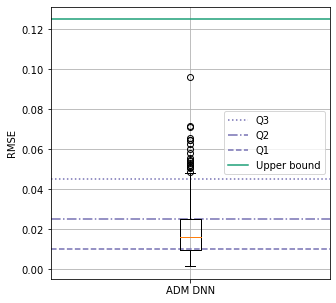

In [22]:
plt.figure(figsize=(5,5))
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
#plt.scatter([2, 2, 2],[0.04, 0.05, 0.075],)
#plt.scatter(2, 0.15)
ls = ['--','-.',':']


plt.plot([0, 2], [0.045, 0.045], ls=ls[2], c=colors[2], label='Q3')
plt.plot([0, 2], [0.025, 0.025], ls=ls[1], c=colors[2], label='Q2')
plt.plot([0, 2], [0.01, 0.01], ls=ls[0], c=colors[2], label='Q1')


plt.plot([0, 2], [0.125, 0.125], c=colors[0],label='Upper bound')
_ = plt.boxplot(all_rmse, labels= ['ADM DNN'])


plt.xlim(0,2)
plt.grid()
plt.ylabel('RMSE')
plt.legend()
#plt.savefig('ADM_DNN_RMSE', dpi=1000)
plt.show()


## Testing on indi dataset

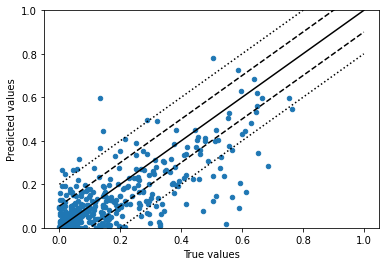

SpearmanrResult(correlation=0.6812067902047214, pvalue=5.975028021821108e-57)
R2: 0.5061847104275192
408 COLO.205


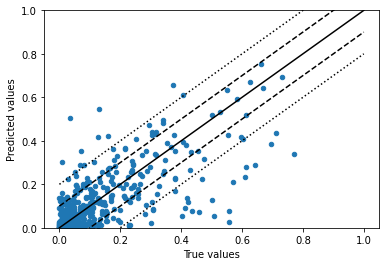

SpearmanrResult(correlation=0.6398712514083535, pvalue=2.275654969076393e-48)
R2: 0.4343972805378248
408 HCT.116


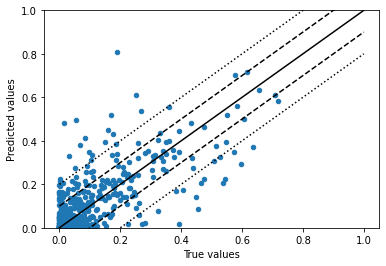

SpearmanrResult(correlation=0.6310155310446905, pvalue=1.3747012508959375e-46)
R2: 0.4021765804521539
407 HT.29


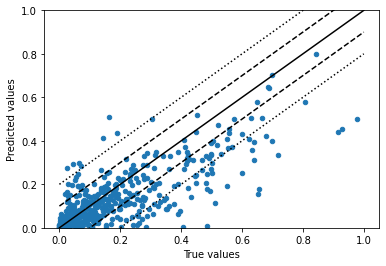

SpearmanrResult(correlation=0.7024097156982305, pvalue=1.3587246773001975e-64)
R2: 0.5120291581820127
426 RKO


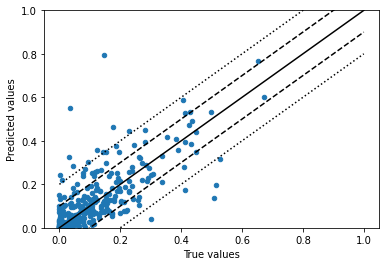

SpearmanrResult(correlation=0.7247809660581489, pvalue=1.0627890102335243e-47)
R2: 0.3635013418596723
285 DLD.1


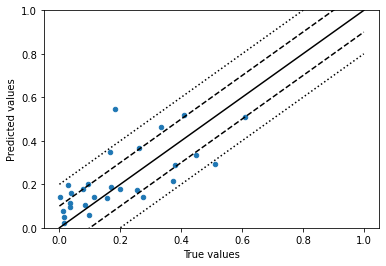

SpearmanrResult(correlation=0.7383689107827038, pvalue=7.272154810427887e-06)
R2: 0.4363496030432773
28 SW480
SpearmanrResult(correlation=0.6812067902047214, pvalue=5.975028021821108e-57)
R2: 0.5061847104275192
408 COLO.205
SpearmanrResult(correlation=0.6398712514083535, pvalue=2.275654969076393e-48)
R2: 0.4343972805378248
408 HCT.116
SpearmanrResult(correlation=0.6310155310446905, pvalue=1.3747012508959375e-46)
R2: 0.4021765804521539
407 HT.29
SpearmanrResult(correlation=0.7024097156982305, pvalue=1.3587246773001975e-64)
R2: 0.5120291581820127
426 RKO
SpearmanrResult(correlation=0.7247809660581489, pvalue=1.0627890102335243e-47)
R2: 0.3635013418596723
285 DLD.1
SpearmanrResult(correlation=0.7383689107827038, pvalue=7.272154810427887e-06)
R2: 0.4363496030432773
28 SW480


In [23]:
r, all_rmse_colo = pre_test(model_rep, x_pp_colo, y_colo)
plot_colo(r, verb = True)
plot_colo(r) #128 with 200 epocs


# 1.2 Unique cell lines vali / test set with same ADM

## Test train split and feature selection

In [24]:
#test train split
train_cls, test_cls = split_data(ppindex)
cls_colo = ppindex_colo.index

In [25]:
#combine data from all drugs into one df
x_pp_train, x_drug_train, y_list_train = create_all_drugs(
    ppindex, y_AML_full_no_norm, train_cls)
print(x_pp_train.shape, x_drug_train.shape, len(y_list_train))


#feature seleciton and getting test data
feature_select_func = emdr_selection

x_pp_train = feature_select(x_pp_train, feature_select_func, test=False)

x_pp_test, y_test = feature_select(
    ppindex, feature_select_func, y=y_AML_full_no_norm, cls=test_cls)

x_pp_colo, y_colo = feature_select(
    ppindex_colo, feature_select_func, y=y_colo_no_norm, 
    cls=y_colo_no_norm.index, indi_dat=True)

(19971, 22804) (19971, 431) 19971


/tmp/2418822.1.all.q/ipykernel_47264/694811990.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_indi[f] = np.zeros(len(x_inid))
/tmp/2418822.1.all.q/ipykernel_47264/694811990.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_indi[f] = np.zeros(len(x_inid))


## Model validation

In [26]:
def run_cv_unique(m_func, x, y, weights, hp, 
                  epochs = 10, k = 10, 
                  p = 1):
    '''Cross validaiton with unique cell lines in vali set
    
    '''
    cv = RepeatedKFold(n_splits = k, n_repeats = p) 
    loss = []
    val_loss = []
    val_mae = []
    x_pp, x_drug = x
    #x needs to be formatted so all 3 repeats come after each other 
    unique_inds = np.arange(0, len(x_pp), 3) 
    i = 0
    for train_i, val_i in cv.split(unique_inds):
        print(i / k)
        i += 1
        train_i = unique_inds[train_i]
        val_i = unique_inds[val_i]
        model = m_func(hp)
        train_i = add_repeats_simp(train_i) 
        val_i = add_repeats_simp(val_i)
        hist = model.fit([x_pp.iloc[train_i], x_drug.iloc[train_i]], 
                         y.iloc[train_i], epochs = epochs,
                         batch_size=64, 
                         validation_data = (
                             [x_pp.iloc[val_i], x_drug.iloc[val_i]], 
                             y.iloc[val_i], weights[val_i]),
                         sample_weight = weights[train_i],
                         verbose = 0)
        loss.append(hist.history['loss'])
        val_loss.append([hist.history['val_loss']])
        val_mae.append(hist.history['val_mae'])
    return loss, val_loss, val_mae

In [27]:
epochs = 20
loss, val_loss, val_mae = run_cv_unique(
    build_DNN, 
    [x_pp_train, x_drug_train], 
    y_list_train, 
    np.ones(len(y_list_train)),
    128, 
    epochs=epochs, 
    p=1, 
    k=3)

0.0
0.3333333333333333
0.6666666666666666


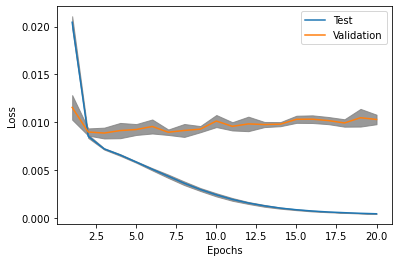

(0.008863387008508047, 2)

In [28]:
plot_cv(loss, val_loss, epochs, err=2) 
best_metric(val_loss)

# 2 RNA models

## Data import 

In [44]:
rna_info = pd.read_csv('downloaded_data/sample_infoCCLE.csv')
all_rna_expression_raw = pd.read_csv('downloaded_data/CCLE_expression.csv')
all_rna_expression_raw.index = all_rna_expression_raw['Unnamed: 0']
all_rna_expression_raw.drop(columns='Unnamed: 0', inplace=True) 
all_rna_expression_raw = all_rna_expression_raw.T
y_rna_full = y_AML_full_no_norm.iloc[: : 3]
y_rna_full.index = [i.replace('.','') for i in y_rna_full.index]

aac_rna_full = read_pharmaco_aac('CCLE_RNA_aac2.csv').T

#norm by cell line
scaler_mm = MinMaxScaler()
all_rna_expression = pd.DataFrame(scaler_mm.fit_transform(all_rna_expression_raw),
                       columns = all_rna_expression_raw.columns,
                       index = all_rna_expression_raw.index).T

In [45]:
id_cl_all = {}
for i, inden in enumerate(rna_info['DepMap_ID']):
    id_cl_all[inden] = rna_info['cell_line_name'][i]
    
#dont re run
#change ids to cell line names 
all_ids = all_rna_expression.index 
all_cls = [id_cl_all[iden] for iden in all_ids]
all_rna_expression.index = all_cls
all_rna_expression = all_rna_expression[all_rna_expression.index.notna()]
inds_temp = all_rna_expression.index
all_rna_expression.index = [i.replace('/' , '-') for i in inds_temp]
i = np.where(all_rna_expression.index == 'SW 480')
inds_temp = all_rna_expression.index.values
inds_temp[i] = 'SW480'
inds_temp = [i.replace('-', '.') for i in inds_temp]
all_rna_expression.index = inds_temp


rna_test_cls = list(test_cls[0: : 3])
rna_colo_cls = list(cls_colo.copy(deep = True)[0: : 3])
rna_colo_cls.remove('COLO.205') #no x values for this
#rna_colo_cls.remove('HCT.116') #cant find y value 


rna_train_cls = set(aac_rna_full.index).difference(
    set(rna_test_cls + rna_colo_cls))
rna_train_cls = list(rna_train_cls)
#most of these missing cls are due to differences in caps between x and y
miss_cls = ['SiHa', 'YAMATO', '22RV1', 'REH', 'Mewo', 'Gp2D', 'LOUCY', 'FADU',
           'CAPAN.1', 'LU.135', 'CAKI.1', 'HuP.T3', 'HuP.T4'] 
for cl in miss_cls:
    rna_train_cls.remove(cl)
    
#get cols in the same format as EMDR's
new_cols = [col.split(' ')[0] for col in all_rna_expression.columns] 
all_rna_expression.columns = new_cols
#change  cl 'HCT 116'  to 'HCT.116' in x and y
cls_temp = np.array(all_rna_expression.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
all_rna_expression.index = cls_temp
cls_temp = np.array(aac_rna_full.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
aac_rna_full.index = cls_temp

### 2.1 Small RNA dataset / model

In [46]:
train_cls_small = list(train_cls[: :3])
train_cls_small.remove('OE19')
rna_colo_cls = list(cls_colo.copy(deep = True)[0: : 3])
rna_colo_cls.remove('COLO.205') #no x values for this


    
#get cols in the same format as EMDR's
new_cols = [col.split(' ')[0] for col in all_rna_expression.columns] 
all_rna_expression.columns = new_cols

#change  cl 'HCT 116'  to 'HCT.116' in x and y
cls_temp = np.array(all_rna_expression.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
all_rna_expression.index = cls_temp
cls_temp = np.array(aac_rna_full.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
aac_rna_full.index = cls_temp

x_smallrna_train = all_rna_expression.loc[train_cls_small] 
y_smallrna_train = aac_rna_full.loc[train_cls_small]
x_smallrna_test = all_rna_expression.loc[test_cls[: : 3]]
y_smallrna_test = aac_rna_full.loc[test_cls[: : 3]]
x_rna_colo = all_rna_expression.loc[rna_colo_cls]
y_rna_colo = aac_rna_full.loc[rna_colo_cls]

#### Feature seleciton

In [48]:
#find EMDRS that are in cols some mistaken EMDRS e.g. 1, 2
overlappng_emdrs = []
for emdr in emdrs_rna:
    if emdr in new_cols:
        overlappng_emdrs.append(emdr)

x_smallrna_train_raw = x_smallrna_train[overlappng_emdrs]
x_smallrna_test_raw = x_smallrna_test[overlappng_emdrs]
x_rna_colo_raw = x_rna_colo[overlappng_emdrs]


mm_scaler = MinMaxScaler()
x_smallrna_train = mm_scaler.fit_transform(x_smallrna_train_raw)
x_smallrna_train = pd.DataFrame(x_smallrna_train, columns=x_smallrna_train_raw.columns,
                           index=x_smallrna_train_raw.index)

x_smallrna_test = mm_scaler.transform(x_smallrna_test_raw)
x_smallrna_test = pd.DataFrame(x_smallrna_test, columns=x_smallrna_test_raw.columns,
                          index=x_smallrna_test_raw.index)

x_rna_colo = mm_scaler.transform(x_rna_colo_raw)
x_rna_colo = pd.DataFrame(x_rna_colo, columns=x_rna_colo_raw.columns, 
                          index=x_rna_colo_raw.index)

In [49]:
x_smallrna_train, xdrug_train, y_smallrna_train = create_all_drugs(
    x_smallrna_train, y_smallrna_train, train_cls_small, data_split=True)

x_smallrna_train.shape, xdrug_train.shape, len(y_smallrna_train)

((6229, 3696), (6229, 431), 6229)

#### Model building and validation

In [50]:
def build_DNN_rna_small(num_uni):
    phos_input = layers.Input(shape=x_smallrna_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    x = layers.Dense(num_uni, activation='relu')(x)
    drug_input = layers.Input(shape=(xdrug_train.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    hidd = layers.Dense(num_uni // 2, activation='relu')(hidd)
    output_tensor = layers.Dense(1, activation='sigmoid')(hidd)
    model = models.Model([phos_input ,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [56]:
epochs = 20
loss, val_loss, val_mae = run_cv(
    build_DNN_rna_small, 
    [x_smallrna_train, xdrug_train], 
    y_smallrna_train, 
    128, 
    epochs=epochs, 
    p=1, 
    k=3)

0.0
0.3333333333333333
0.6666666666666666


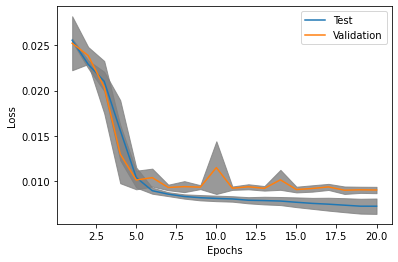

(0.009033373246590296, 17)

In [57]:
plot_cv(loss, val_loss, epochs) 
best_metric(val_loss)

In [53]:
model_small = build_DNN_rna_small(128)
_ = model_small.fit([x_smallrna_train, xdrug_train], y_smallrna_train, 
                  epochs=10, batch_size=8)

Epoch 1/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0250 - mae: 0.1181
Epoch 2/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0225 - mae: 0.1130
Epoch 3/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0180 - mae: 0.1004
Epoch 4/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0104 - mae: 0.0731
Epoch 5/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0088 - mae: 0.0655
Epoch 6/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0086 - mae: 0.0638
Epoch 7/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0082 - mae: 0.0623
Epoch 8/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0082 - mae: 0.0618
Epoch 9/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0080 - mae: 0.0612
Epoch 10/10
779/779 [==============================] - 3s 4ms/step - loss: 0.0079 - mae: 0.0608


#### Testing on testing data

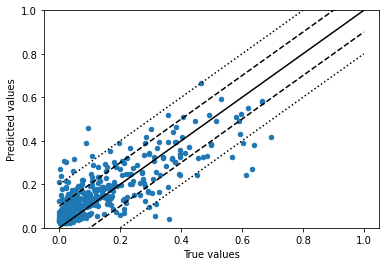

SpearmanrResult(correlation=0.7481192170872957, pvalue=2.345677912927593e-77)
R2: 0.6028154227156688
425 SK.HEP.1


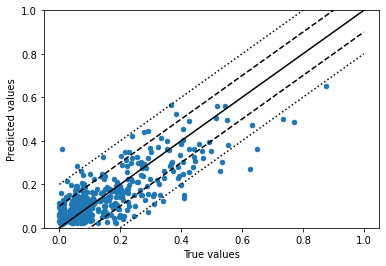

SpearmanrResult(correlation=0.7155310368064336, pvalue=4.150292367994312e-67)
R2: 0.6380713124697349
420 OE33


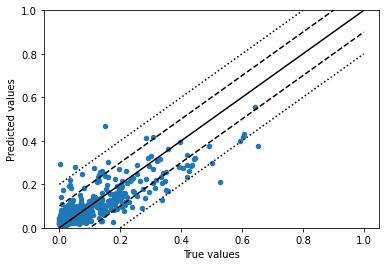

SpearmanrResult(correlation=0.754596094900466, pvalue=7.625921875953379e-77)
R2: 0.64133782172813
411 COLO.680N


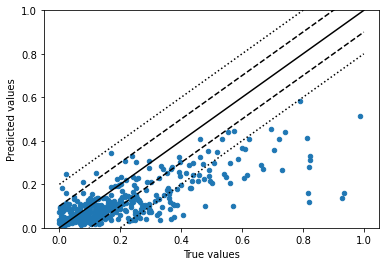

SpearmanrResult(correlation=0.7030045058205776, pvalue=2.1305489736960658e-59)
R2: 0.30454363785322847
390 SNU.398
 
SpearmanrResult(correlation=0.7481192170872957, pvalue=2.345677912927593e-77)
R2: 0.6028154227156688
425 SK.HEP.1
SpearmanrResult(correlation=0.7155310368064336, pvalue=4.150292367994312e-67)
R2: 0.6380713124697349
420 OE33
SpearmanrResult(correlation=0.754596094900466, pvalue=7.625921875953379e-77)
R2: 0.64133782172813
411 COLO.680N
SpearmanrResult(correlation=0.7030045058205776, pvalue=2.1305489736960658e-59)
R2: 0.30454363785322847
390 SNU.398


In [54]:
r, all_rmse_colo = pre_test(model_small, x_smallrna_test, y_smallrna_test)
plot_colo(r, re=1, verb=True)
print(' ')
r2_small, spear_small, cls_order = plot_colo(r, re=1, ret=True)

#### Testing on inidipedent colo data

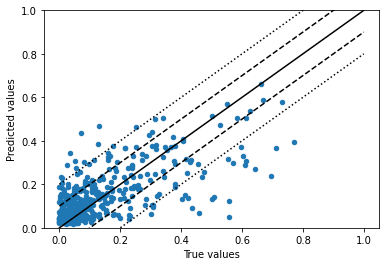

SpearmanrResult(correlation=0.6090825823024966, pvalue=8.701777369466474e-43)
R2: 0.44299022620194894
408 HCT.116


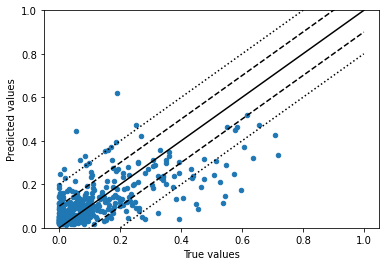

SpearmanrResult(correlation=0.6006115512825602, pvalue=2.937465718255279e-41)
R2: 0.43255031177474423
407 HT.29


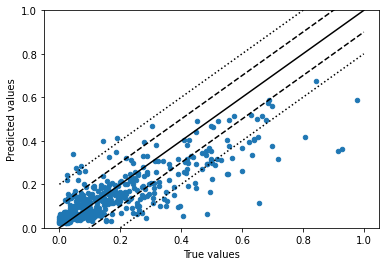

SpearmanrResult(correlation=0.7602582594960735, pvalue=1.8799582488856184e-81)
R2: 0.5856410685579412
426 RKO


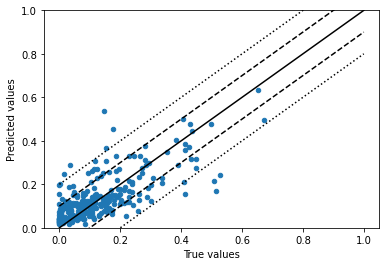

SpearmanrResult(correlation=0.7156617789212757, pvalue=5.120174058285447e-46)
R2: 0.532591347320672
285 DLD.1


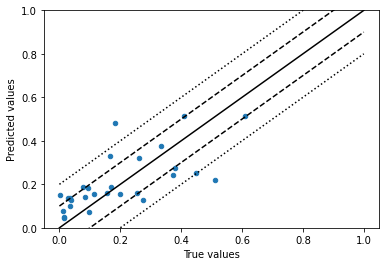

SpearmanrResult(correlation=0.7651888341543513, pvalue=2.107353002291681e-06)
R2: 0.47095842874454286
28 SW480
 
SpearmanrResult(correlation=0.6090825823024966, pvalue=8.701777369466474e-43)
R2: 0.44299022620194894
408 HCT.116
SpearmanrResult(correlation=0.6006115512825602, pvalue=2.937465718255279e-41)
R2: 0.43255031177474423
407 HT.29
SpearmanrResult(correlation=0.7602582594960735, pvalue=1.8799582488856184e-81)
R2: 0.5856410685579412
426 RKO
SpearmanrResult(correlation=0.7156617789212757, pvalue=5.120174058285447e-46)
R2: 0.532591347320672
285 DLD.1
SpearmanrResult(correlation=0.7651888341543513, pvalue=2.107353002291681e-06)
R2: 0.47095842874454286
28 SW480


In [58]:
r, all_rmse_colo = pre_test(model_small, x_rna_colo, y_colo.loc[rna_colo_cls])
plot_colo(r, re=1, verb=True)
print(' ')
r2_smallc, spear_smallc, cls_orderc = plot_colo(r, re=1, ret=True)

### 2.2 Big RNA data / model

#### Test train split

In [59]:
rna_test_cls = list(test_cls[0: : 3])
rna_colo_cls = list(cls_colo.copy(deep = True)[0: : 3])
rna_colo_cls.remove('COLO.205') #no x values for this
#rna_colo_cls.remove('HCT.116') #cant find y value 


rna_train_cls = set(aac_rna_full.index).difference(
    set(rna_test_cls + rna_colo_cls))
rna_train_cls = list(rna_train_cls)
#most of these missing cls are due to differences in caps between x and y
miss_cls = ['SiHa', 'YAMATO', '22RV1', 'REH', 'Mewo', 'Gp2D', 'LOUCY', 'FADU',
           'CAPAN.1', 'LU.135', 'CAKI.1', 'HuP.T3', 'HuP.T4'] 
for cl in miss_cls:
    rna_train_cls.remove(cl)
    
#get cols in the same format as EMDR's
new_cols = [col.split(' ')[0] for col in all_rna_expression.columns] 
all_rna_expression.columns = new_cols
#change  cl 'HCT 116'  to 'HCT.116' in x and y
cls_temp = np.array(all_rna_expression.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
all_rna_expression.index = cls_temp
cls_temp = np.array(aac_rna_full.index)
ind = np.where(cls_temp=='HCT 116')[0]
cls_temp[ind] = 'HCT.116'
aac_rna_full.index = cls_temp


aac_rna_full
x_rna_train = all_rna_expression.loc[rna_train_cls] 
y_rna_train = aac_rna_full.loc[rna_train_cls]
x_rna_test = all_rna_expression.loc[rna_test_cls]
y_rna_test = aac_rna_full.loc[rna_test_cls]
x_rna_colo = all_rna_expression.loc[rna_colo_cls]
y_rna_colo = aac_rna_full.loc[rna_colo_cls]

#### Feature selection

In [60]:
#find EMDRS that are in cols some mistaken EMDRS e.g. 1, 2
overlappng_emdrs = []
for emdr in emdrs_rna:
    if emdr in new_cols:
        overlappng_emdrs.append(emdr)

x_rna_train_raw = x_rna_train[overlappng_emdrs]
x_rna_test_raw = x_rna_test[overlappng_emdrs]
x_rna_colo_raw = x_rna_colo[overlappng_emdrs]


mm_scaler = MinMaxScaler()
x_rna_train = mm_scaler.fit_transform(x_rna_train_raw)
x_rna_train = pd.DataFrame(x_rna_train, columns=x_rna_train_raw.columns,
                           index=x_rna_train_raw.index)

x_rna_test = mm_scaler.transform(x_rna_test_raw)
x_rna_test = pd.DataFrame(x_rna_test, columns=x_rna_test_raw.columns,
                          index=x_rna_test_raw.index)

x_rna_colo = mm_scaler.transform(x_rna_colo_raw)
x_rna_colo = pd.DataFrame(x_rna_colo, columns=x_rna_colo_raw.columns, 
                          index=x_rna_colo_raw.index)

In [61]:
x_rna_train, xdrug_train, y_rna_train = create_all_drugs(
    x_rna_train, y_rna_train, rna_train_cls, data_split=True)

#### Model building and validaiton

In [62]:
def build_DNN_rna(num_uni):
    phos_input = layers.Input(shape=x_rna_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    x = layers.Dense(num_uni, activation='relu')(x)
    drug_input = layers.Input(shape=(xdrug_train.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    hidd = layers.Dense(num_uni // 2, activation='relu')(hidd)
    output_tensor = layers.Dense(1, activation='sigmoid')(hidd)
    model = models.Model([phos_input ,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [63]:
epochs = 50
loss, val_loss, val_mae = run_cv(
    build_DNN_rna, 
    [x_rna_train, xdrug_train], 
    y_rna_train, 
    128, 
    epochs=epochs, 
    p=1, 
    k=3)

0.0


KeyboardInterrupt: 

In [ ]:
plot_cv(loss, val_loss, epochs) 
best_metric(val_loss)

In [65]:
model_rep = build_DNN_rna(128)
_ = model_rep.fit([x_rna_train, xdrug_train], y_rna_train, 
                  epochs=50, batch_size=8)

Epoch 1/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0139 - mae: 0.0825
Epoch 2/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0118 - mae: 0.0756
Epoch 3/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0116 - mae: 0.0747
Epoch 4/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0114 - mae: 0.0742
Epoch 5/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0114 - mae: 0.0739
Epoch 6/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0113 - mae: 0.0738
Epoch 7/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0113 - mae: 0.0736
Epoch 8/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0112 - mae: 0.0734
Epoch 9/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0112 - mae: 0.0733
Epoch 10/50
34209/34209 [==============================] - 116s 3ms/step - loss: 0.0112 - m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34209/34209 [==============================] - 116s 3ms/step - loss: 0.0111 - mae: 0.0730
Epoch 48/50
25352/34209 [=====================>........] - ETA: 30s - loss: 0.0111 - mae: 0.0730

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Testing on testing data

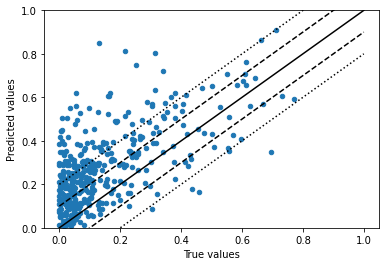

SpearmanrResult(correlation=0.5515279014355989, pvalue=7.58453702502651e-34)
R2: -0.511609368975688
408 HCT.116


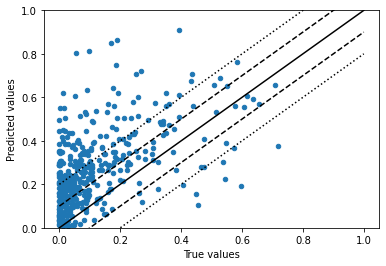

SpearmanrResult(correlation=0.5244622378647179, pvalue=3.8596877070689425e-30)
R2: -1.2754238686409054
407 HT.29


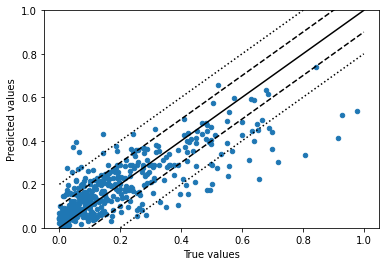

SpearmanrResult(correlation=0.7748873009902341, pvalue=1.7025172245841378e-86)
R2: 0.6276855646679693
426 RKO


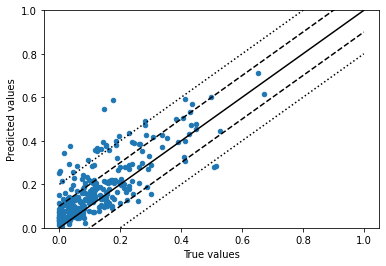

SpearmanrResult(correlation=0.7530024913893824, pvalue=2.285273907234274e-53)
R2: 0.3129592089405103
285 DLD.1


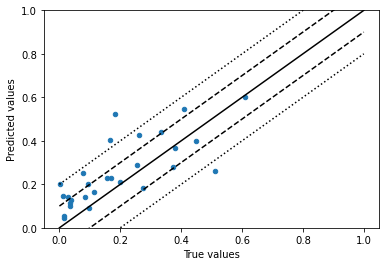

SpearmanrResult(correlation=0.78544061302682, pvalue=7.392509334904097e-07)
R2: 0.4031061433341302
28 SW480
 
SpearmanrResult(correlation=0.5515279014355989, pvalue=7.58453702502651e-34)
R2: -0.511609368975688
408 HCT.116
SpearmanrResult(correlation=0.5244622378647179, pvalue=3.8596877070689425e-30)
R2: -1.2754238686409054
407 HT.29
SpearmanrResult(correlation=0.7748873009902341, pvalue=1.7025172245841378e-86)
R2: 0.6276855646679693
426 RKO
SpearmanrResult(correlation=0.7530024913893824, pvalue=2.285273907234274e-53)
R2: 0.3129592089405103
285 DLD.1
SpearmanrResult(correlation=0.78544061302682, pvalue=7.392509334904097e-07)
R2: 0.4031061433341302
28 SW480


In [66]:
r, all_rmse_colo = pre_test(model_rep, x_rna_colo, y_colo.loc[rna_colo_cls])
plot_colo(r, re=1, verb=True)
print(' ')
r2_c, spear_c, cls_order = plot_colo(r, re=1, ret=True)

#### Testing on indipedent colo data

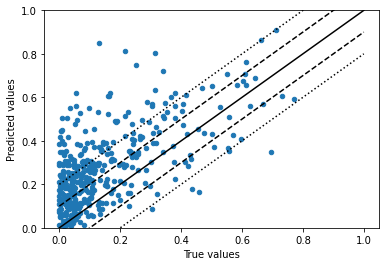

SpearmanrResult(correlation=0.5515279014355989, pvalue=7.58453702502651e-34)
R2: -0.511609368975688
408 HCT.116


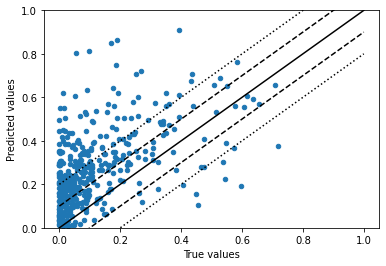

SpearmanrResult(correlation=0.5244622378647179, pvalue=3.8596877070689425e-30)
R2: -1.2754238686409054
407 HT.29


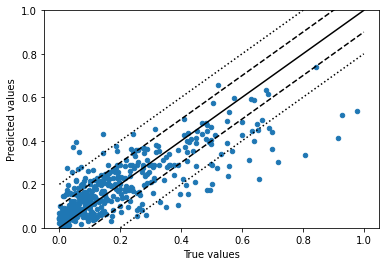

SpearmanrResult(correlation=0.7748873009902341, pvalue=1.7025172245841378e-86)
R2: 0.6276855646679693
426 RKO


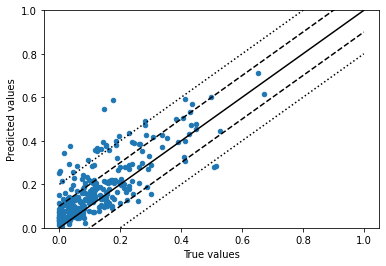

SpearmanrResult(correlation=0.7530024913893824, pvalue=2.285273907234274e-53)
R2: 0.3129592089405103
285 DLD.1


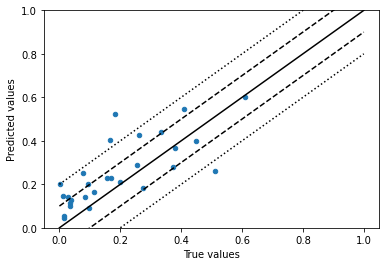

SpearmanrResult(correlation=0.78544061302682, pvalue=7.392509334904097e-07)
R2: 0.4031061433341302
28 SW480
 
SpearmanrResult(correlation=0.5515279014355989, pvalue=7.58453702502651e-34)
R2: -0.511609368975688
408 HCT.116
SpearmanrResult(correlation=0.5244622378647179, pvalue=3.8596877070689425e-30)
R2: -1.2754238686409054
407 HT.29
SpearmanrResult(correlation=0.7748873009902341, pvalue=1.7025172245841378e-86)
R2: 0.6276855646679693
426 RKO
SpearmanrResult(correlation=0.7530024913893824, pvalue=2.285273907234274e-53)
R2: 0.3129592089405103
285 DLD.1
SpearmanrResult(correlation=0.78544061302682, pvalue=7.392509334904097e-07)
R2: 0.4031061433341302
28 SW480


ValueError: too many values to unpack (expected 2)

In [67]:
r, all_rmse_colo = pre_test(model_rep, x_rna_colo, y_colo.loc[rna_colo_cls])
plot_colo(r, re=1, verb=True)
print(' ')
r2_c, spear_c = plot_colo(r, re=1, ret=True)

# 3 Stats tests

In [68]:
adm_rcl = np.array([0.65, 0.61, 0.61, 0.73, 0.71, 0.71])
druml_rf = np.array([0.67, 0.61, 0.65, 0.73, 0.69, 0.83])
druml_dl = np.array([0.64, 0.59, 0.62, 0.63, 0.66, 0.75])

In [69]:
scipy.stats.ttest_ind(adm_rcl, druml_rf), scipy.stats.ttest_ind(adm_rcl, druml_dl) #table 1

(Ttest_indResult(statistic=-0.6984302957695799, pvalue=0.5008270842295441),
 Ttest_indResult(statistic=0.6911374686451955, pvalue=0.5052062170574989))

In [70]:
amd_ucl = np.array([0.66, 0.60, 0.61, 0.76, 0.72, 0.74, 0.73, 0.71, 0.76, 0.70])
scipy.stats.ttest_ind(amd_ucl[: 6], druml_rf), scipy.stats.ttest_ind(amd_ucl[: 6], adm_rcl) #table 2

(Ttest_indResult(statistic=-0.3581708360524949, pvalue=0.7276607379435549),
 Ttest_indResult(statistic=0.32917948466898095, pvalue=0.7488106087920589))

In [71]:
mean_model = np.array([0.68, 0.622, 0.61, 0.77, 0.72, 
                       0.77, 0.7, 0.73, 0.75, 0.72])
scipy.stats.ttest_ind(mean_model, amd_ucl), scipy.stats.ttest_ind(mean_model, adm_rcl), scipy.stats.ttest_ind(mean_model[:6], druml_rf)  #table 3

(Ttest_indResult(statistic=0.32313753219059665, pvalue=0.7503148263443472),
 Ttest_indResult(statistic=1.307988601279974, pvalue=0.21194730691238065),
 Ttest_indResult(statistic=-0.031430848643973885, pvalue=0.9755444157691382))

In [72]:
rna_small = np.array([0.61, 0.6, 0.76, 0.72, 0.77, 0.74, 0.72, 0.75, 0.71]) #table 4
scipy.stats.ttest_ind(rna_small, mean_model), scipy.stats.ttest_ind(rna_small, amd_ucl)

(Ttest_indResult(statistic=0.0624182450885657, pvalue=0.9509577813022658),
 Ttest_indResult(statistic=0.3599482230588565, pvalue=0.723318692965973))

In [74]:
rna_big = np.array([0.55, 0.52, 0.78, 0.75, 0.79, 0.79, 0.73, 0.78, 0.66]) #table 5
scipy.stats.ttest_ind(rna_big, mean_model), scipy.stats.ttest_ind(rna_big, amd_ucl), scipy.stats.ttest_ind(rna_big, rna_small)

(Ttest_indResult(statistic=-0.04319916512184579, pvalue=0.9660461207632476),
 Ttest_indResult(statistic=0.17088220773475124, pvalue=0.8663337708295317),
 Ttest_indResult(statistic=-0.0818164914122701, pvalue=0.9358074007146815))